<a href="https://colab.research.google.com/github/wldopie/ESAA/blob/main/%5B%EC%88%98%EC%83%81%EC%9E%91_%EC%8A%A4%ED%84%B0%EB%94%94_2%EC%A1%B0%5D_1%EC%A3%BC%EC%B0%A8_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **자율주행 센서의 안테나 성능 예측 AI 경진대회 (3등 수상작)**
> 링크 : https://dacon.io/competitions/official/235927/codeshare/6653?page=1&dtype=recent

---

## **1. 코드 실행환경**

In [ ]:
import platform
platform.platform()

'Linux-5.10.147+-x86_64-with-glibc2.29'

In [ ]:
!cat /etc/issue.net

Ubuntu 20.04.5 LTS


In [ ]:
!python --version

Python 3.8.10


In [ ]:
!nvidia-smi

Wed Feb  8 00:59:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **1.1 데이터 입/출력 경로 지정**

In [ ]:
# 구글 드라이브 연결
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# 원본 데이터 압축 해제
!unzip -qq '/content/gdrive/MyDrive/[22-2] ESAA 스터디/open.zip'

### **1.2 필요 라이브러리 설치**

In [ ]:
# Optuna 설치
!pip install --quiet optuna

# Catboost 설치
!pip install --quiet catboost

# XGB GPU 버전 설치
!pip uninstall --quiet -y xgboost
!pip install --quiet xgboost

# LGBM GPU 버전 설치
! git clone --recursive https://github.com/Microsoft/LightGBM
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.7 MB/s eta 0:00:00
Cloning into 'LightGBM'...
remote: Enumerating objects: 28834, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 28834 (delta 33), reused 60 (delta 28), pack-reused 28742
Receiving objects: 100% (28834/28834), 20.18 MiB | 21.28 MiB/s, done.
Resolving deltas: 100% (21360/21360), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute

### **1.3 라이브러리 임포트**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna 
from optuna import Trial, visualization

import joblib

import warnings

warnings.filterwarnings("ignore")

### **1.4 랜덤시드 고정**

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) 
SEED = 42

---

## **2. 데이터 시각화**

### **2.1 데이터 로딩**

In [ ]:
# 데이터 로딩
train = pd.read_csv('/content/train.csv')

# X, y 데이터 분리
X_train = train.filter(regex = 'X')   # Input : X feature
Y_train = train.filter(regex = 'Y')   # Output : Y feature

### **2.2 검사 통과 여부 변수 확인 (X_04, X_23, X_47, X_48)**

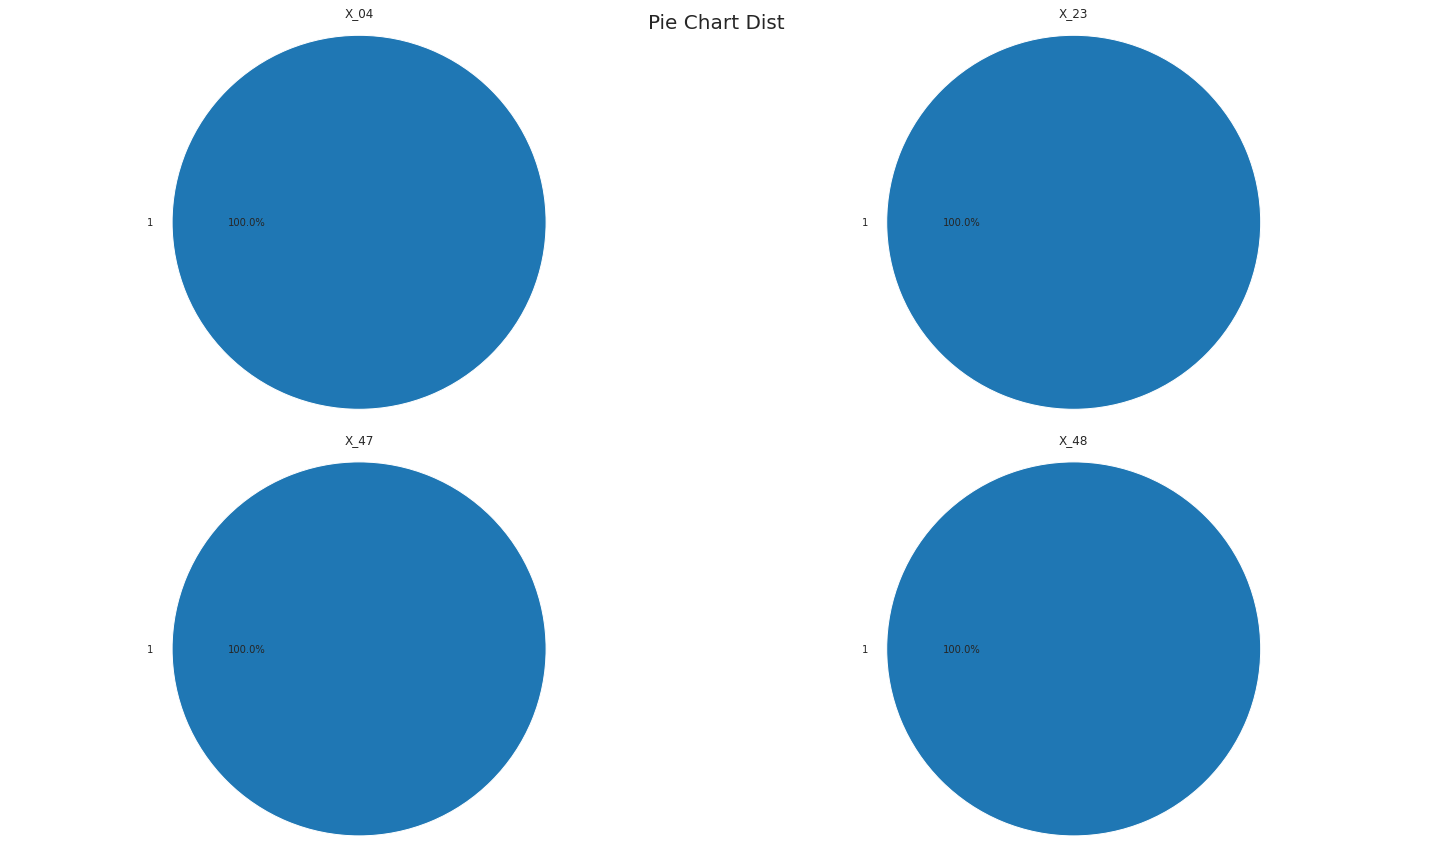

In [ ]:
# 시각화
sns.set_style('whitegrid')
dataset2 = train[['X_04','X_23','X_47','X_48']]

fig = plt.figure(figsize=(20,12))
plt.suptitle("Pie Chart Dist", fontsize=20)
for i in range(1,5):
    plt.subplot(2,2,i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i-1])
    values = dataset2.iloc[:, i-1].value_counts(normalize=True).values
    index = dataset2.iloc[:, i-1].value_counts(normalize=True).index
    
    plt.pie(values, labels = index, autopct='%1.1f%%')
    plt.axis('equal')
    
plt.tight_layout()

  - `X_04`, `X_23`, `X_47`, `X_48` : `1~4차 검사 통과 여부`를 나타내는 변수
  - 위의 파이차트를 통해 알 수 있듯이, 모든 데이터가 1~4차 검사를 통과했으므로 변별력이 없다고 판단하여 추후 분석시 `제거`한다.

### **2.3 방열재료 무게 변수 확인 (X_03, X_10, X_11)**

In [ ]:
# plot
def show_plot(data,columns):
    for col in columns:
        plt.figure(figsize=(36,12))
        plt.plot(data[col])
        plt.title(f'{col}', fontsize=40)
        plt.tight_layout()

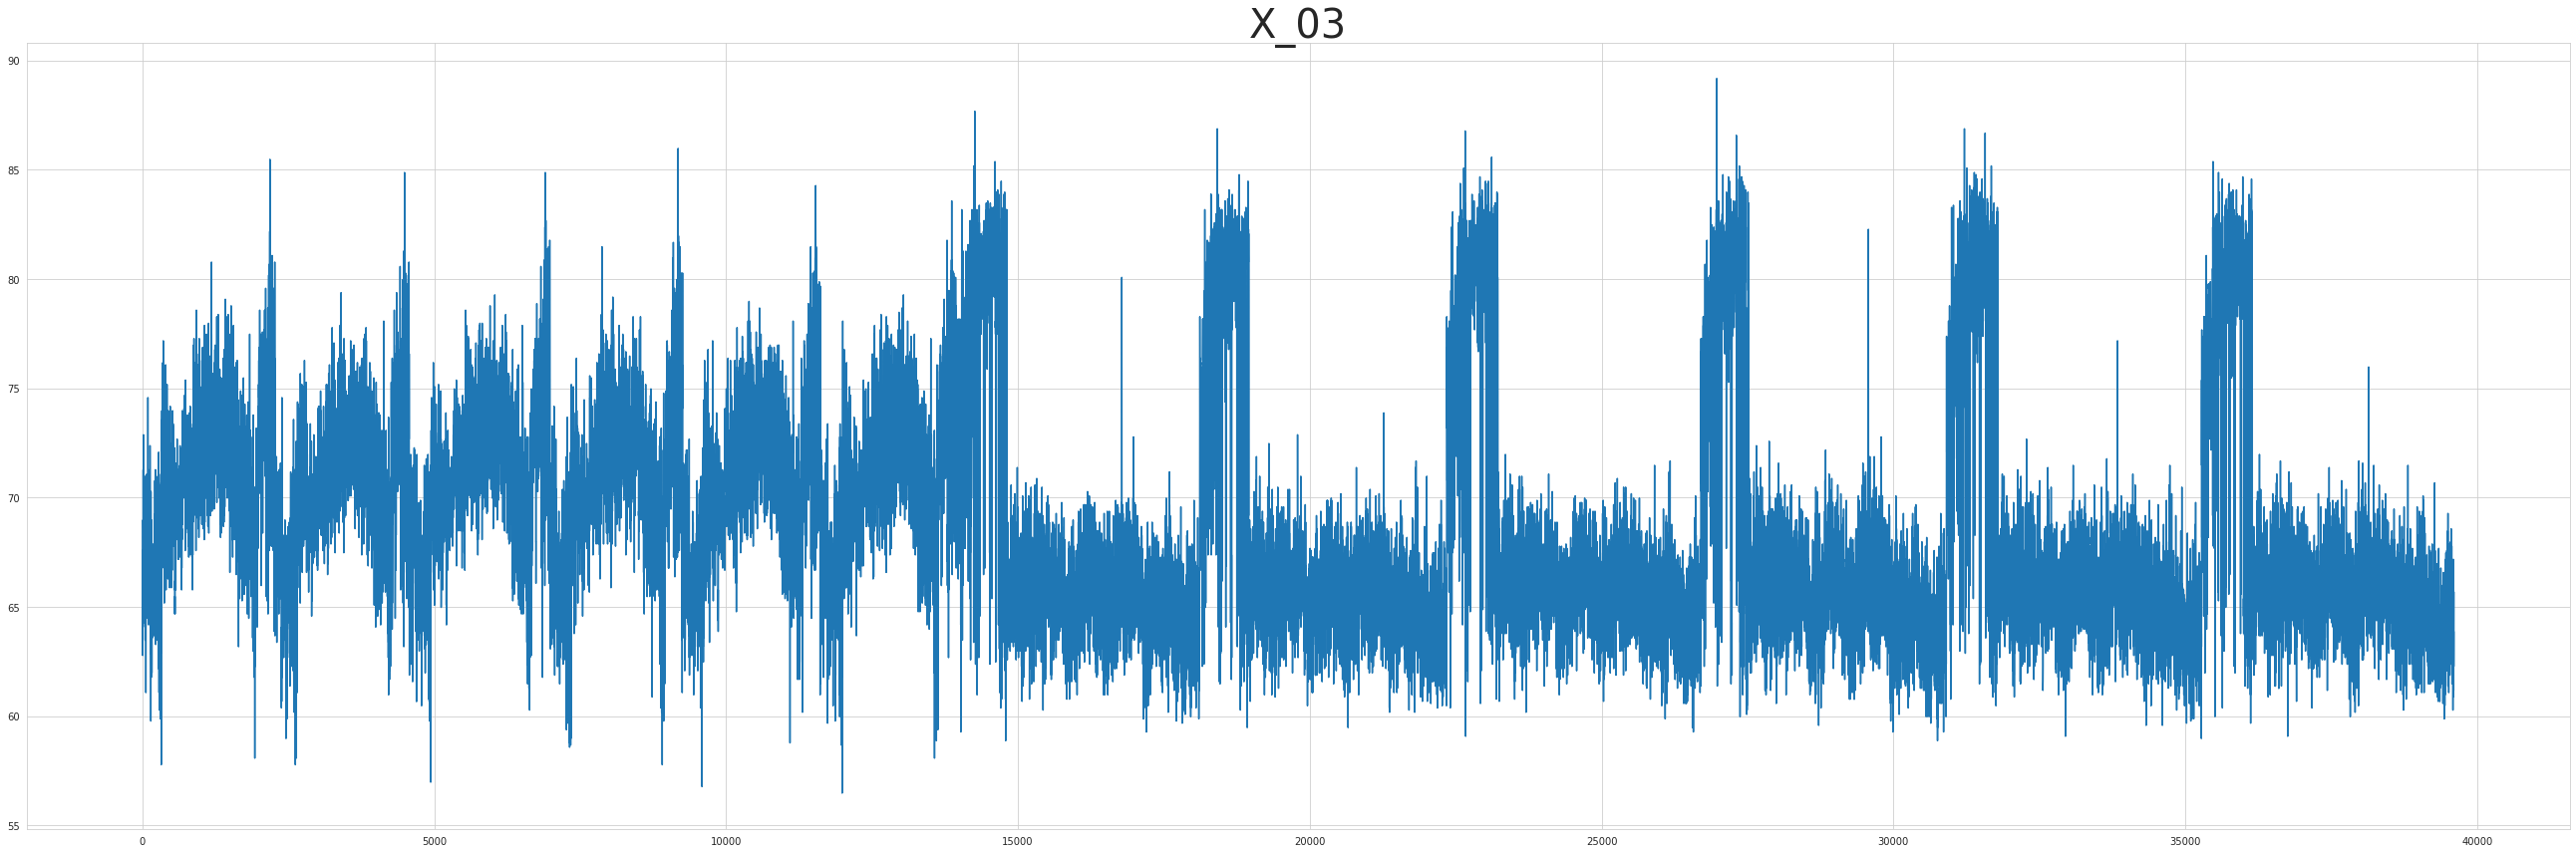

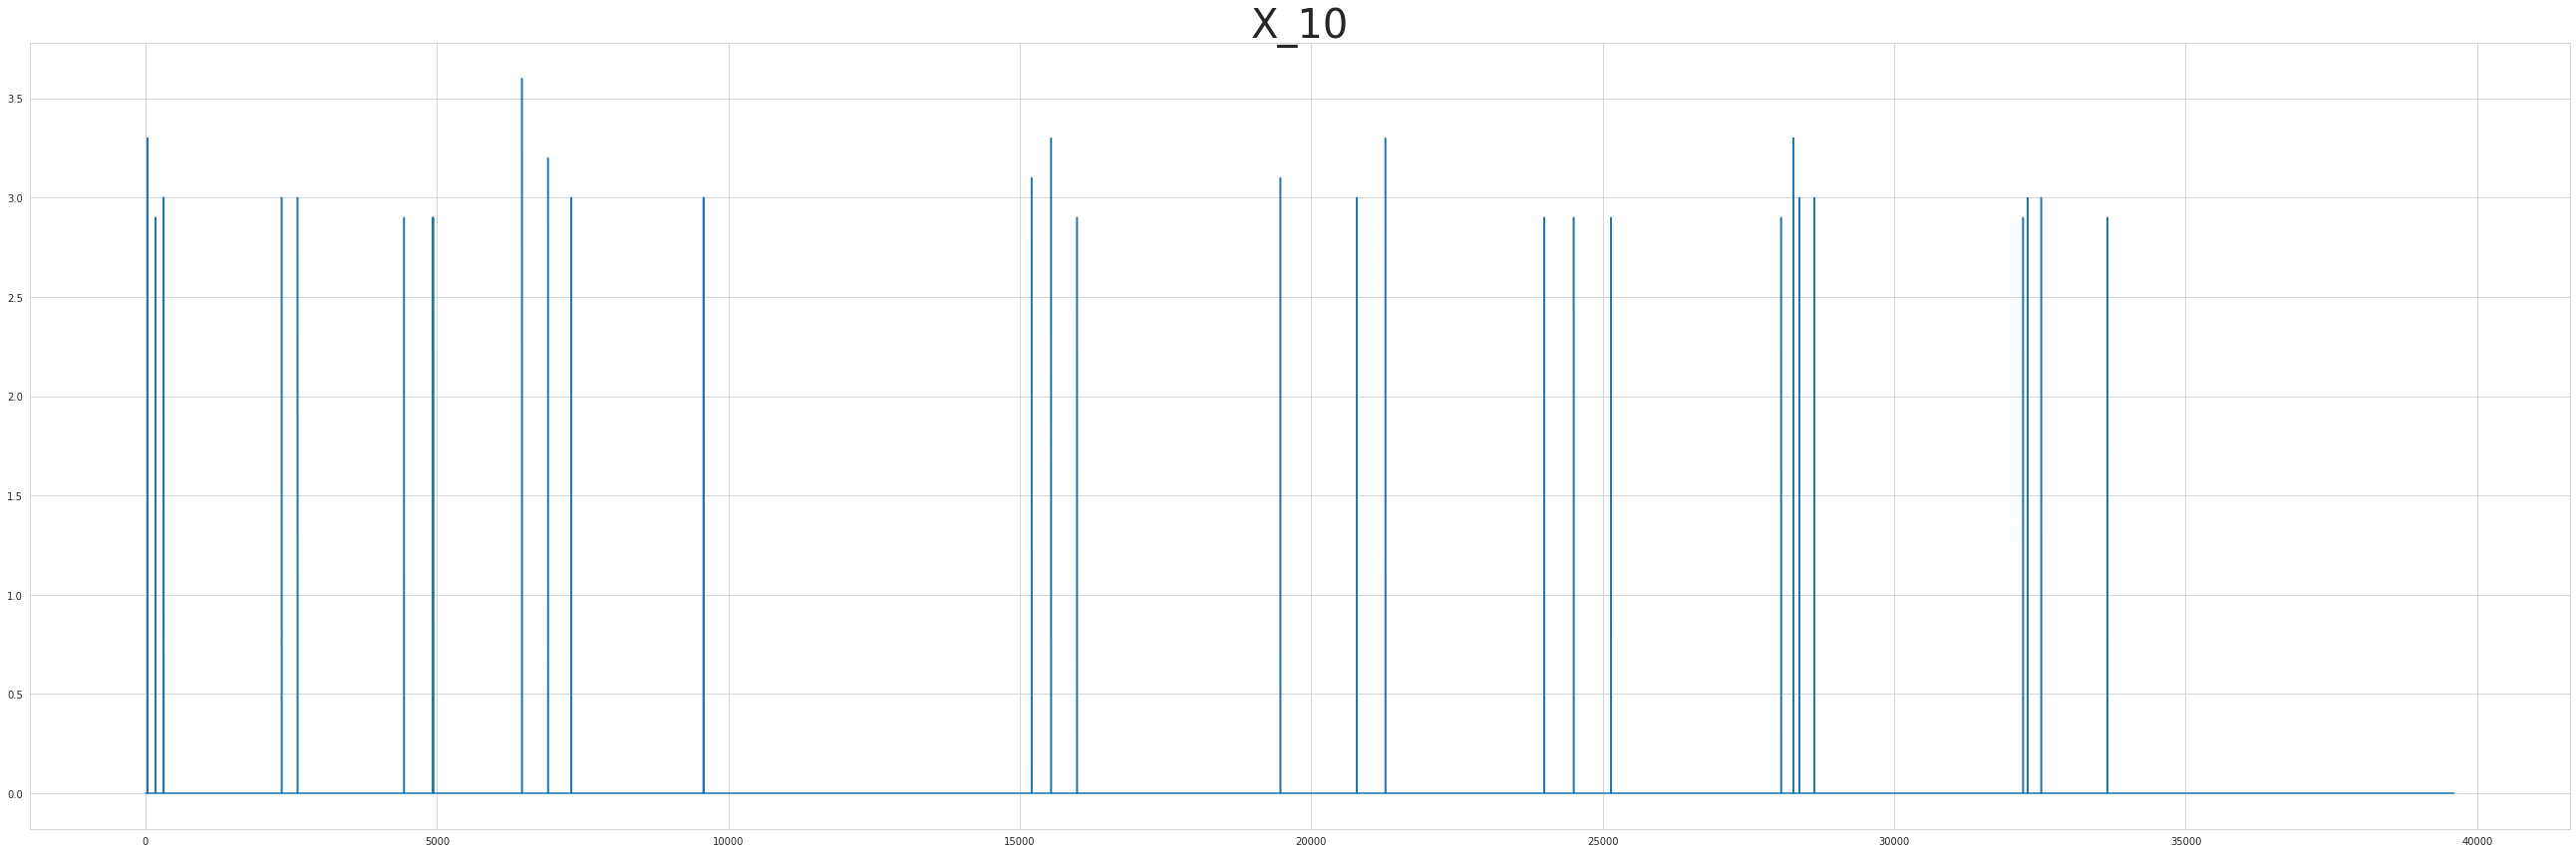

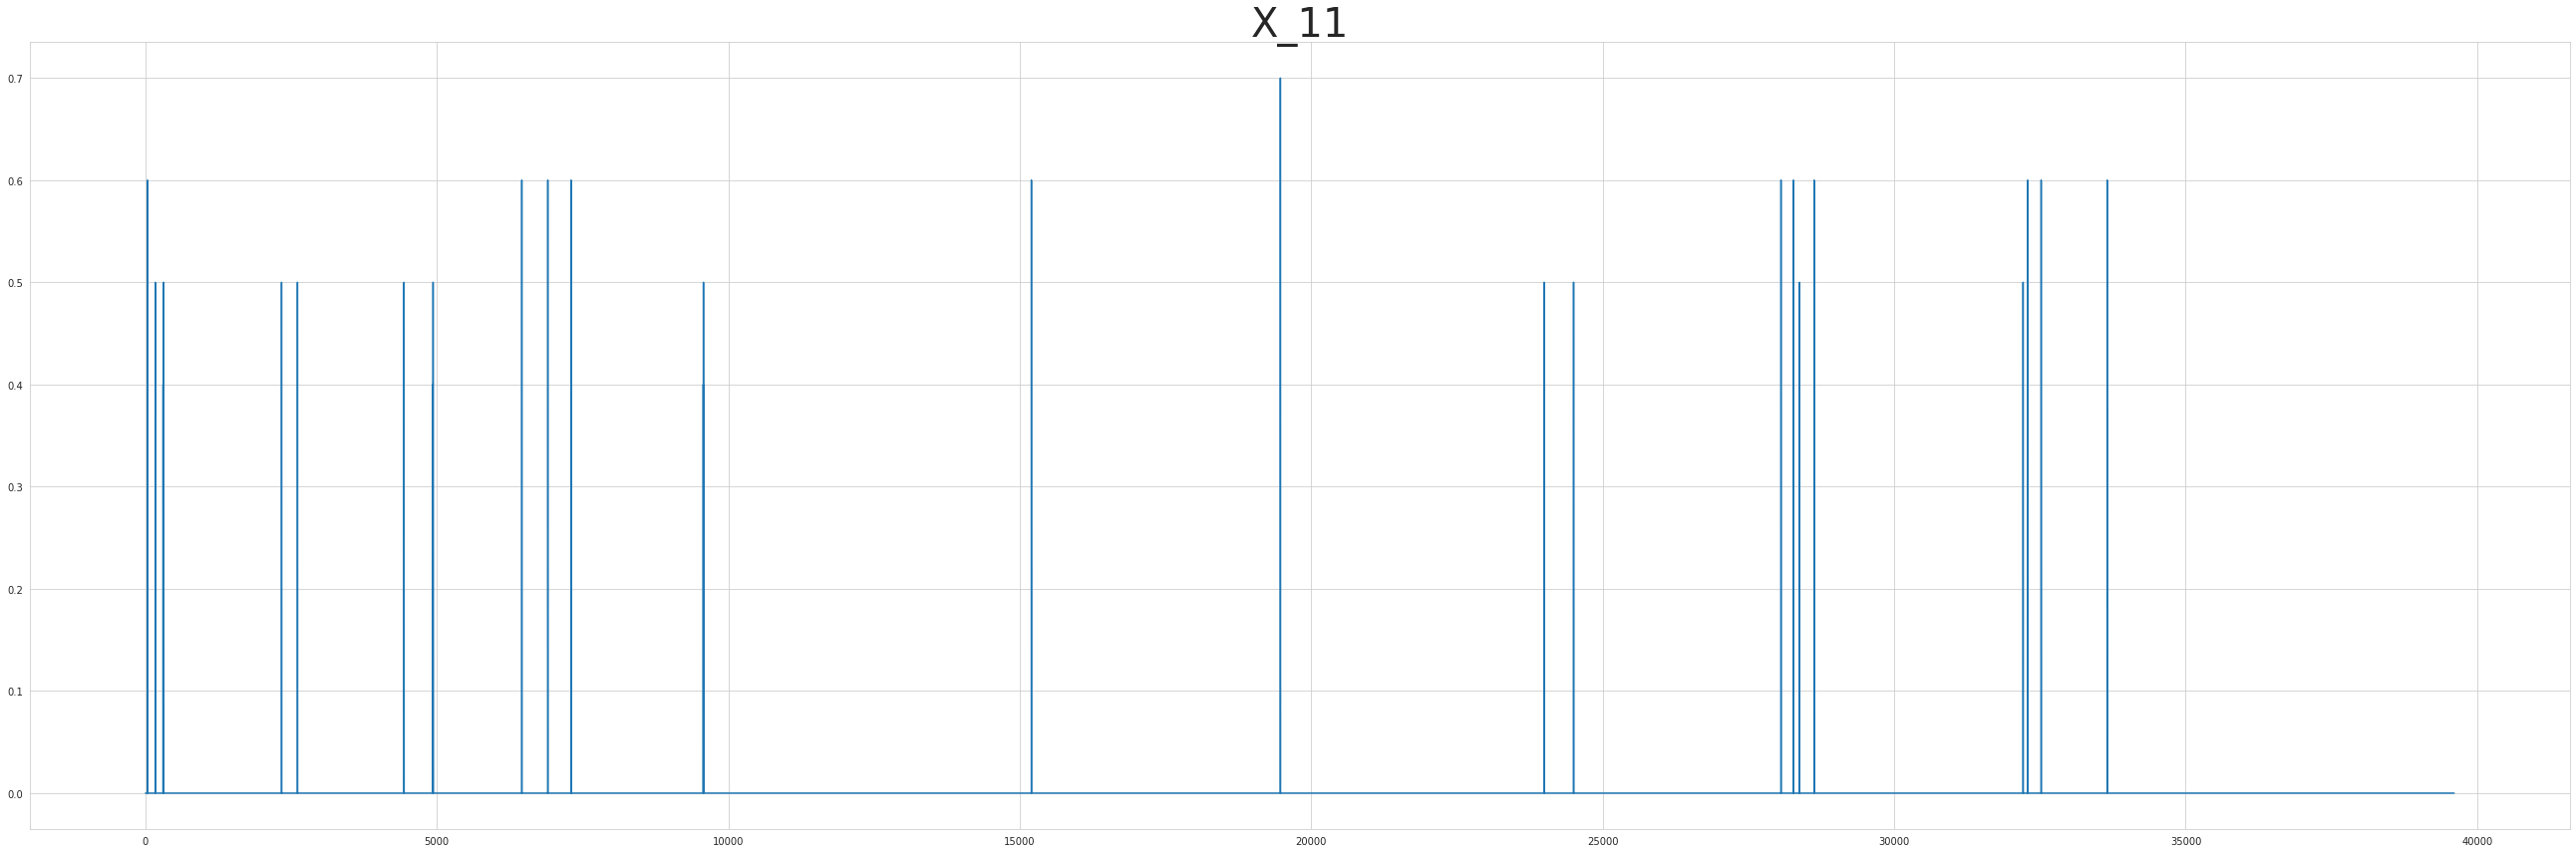

In [ ]:
# 시각화
show_plot(train,["X_03", "X_10", "X_11"])

  - 데이터를 시각화해보니 방열재료 2, 3 무게의 대부분이 0인 것으로 확인된다.
  - 방열재료 2, 3 무게 변수에서 0이 차지하는 비율을 출력해보자.

In [ ]:
# 방열재료 2, 3 무게 변수에서 0이 차지하는 비율 확인
print(len(X_train[X_train['X_10'] == 0]) / len(X_train))
print(len(X_train[X_train['X_11'] == 0]) / len(X_train))

0.9991920620092408
0.999318302320297


  - 방열재료 2, 3 무게 변수 모두 0의 비율이 약 0.999로 거의 모든 값이 0이다.
  - 따라서 `X_10`, `X_11` 변수도 추후 분석시 `제거`한다.

---

## **3. 데이터 전처리**

### **3.1 변수 제거**

In [ ]:
# 결과에 영향이 낮은 인자 제거
X_train = X_train.drop(['X_04', 'X_23', 'X_47', 'X_48', 'X_10', 'X_11', 'X_02'], axis = 1)

### **3.2 이상치 제거**

In [ ]:
# X_33 이상치 제거
drop_idx = X_train.loc[X_train['X_33'] > 6].index

X_train = X_train.drop(drop_idx, axis = 0)
Y_train = Y_train.drop(drop_idx, axis = 0)

X_train = X_train.reset_index(drop = True)
Y_train = Y_train.reset_index(drop = True)

---

## **4. 평가산식 정의 (NRMSE)**

In [ ]:
def nrmse(y_val, y_pred):
  rmse = mean_squared_error(y_val, y_pred, squared=False)
  nrmse = rmse/np.mean(np.abs(y_val))
  return nrmse

def lg_nrmse(y_val, y_pred):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여

    y_val = pd.DataFrame(y_val)
    y_pred = pd.DataFrame(y_pred)

    all_nrmse = []
    for idx in range(0,14):
        all_nrmse.append(nrmse(y_val.iloc[:,idx], y_pred.iloc[:,idx]))
        
    score = 1.2 * np.sum(all_nrmse[:7]) + 1.0 * np.sum(all_nrmse[7:14])
    return score

---

## **5. PCA 최적화 준비**
  - 최적의 성능을 보이는 PCA를 탐색하기 위한 과정
  - 이 과정을 통해 최적으로 튜닝된 PCA 조합을 최종 데이터셋으로 결정

In [ ]:
# PCA 클래스 설정
class PCA_transform:

  def __init__(self):
    self.cols_list = []
    self.pca_list = []
    self.n_pca_list = []
    self.size = 0
  
  # PCA 클래스의 학습 및 input 값 변환
  def fit_transform(self, X_input, col, n_pca):
    
    if (n_pca == 0):
      return X_input

    X_pca = X_input[col]

    # n차원으로 차원 축소, target 정보는 제외
    pca = PCA(n_components = n_pca)

    # PCA 학습
    pca.fit(X_pca)

    # PCA transform 후 데이터프레임으로 자료형 변경
    X_pca = pca.transform(X_pca)
    X_pca = pd.DataFrame(X_pca, columns = self.naming(n_pca))

    X_input = pd.concat([X_input, X_pca], axis = 1)
    X_input = X_input.drop(col, axis = 1)

    self.cols_list.append(col)
    self.pca_list.append(pca)
    self.n_pca_list.append(n_pca)
    self.size += 1

    return X_input

  # 학습된 PCA 값으로 transform
  def transform(self, X_input):
    for idx in range(self.size):
      X_input = self._idx_transform(X_input, idx)
    
    return X_input

  # n번째 PCA 변환
  def _idx_transform(self, X_input, idx):
    X_pca = X_input[self.cols_list[idx]]

    # pca transform 후 데이터프레임으로 자료형 변경
    X_pca = self.pca_list[idx].transform(X_pca)
    X_pca = pd.DataFrame(X_pca, columns = self.naming(self.n_pca_list[idx], idx))
    
    X_input = pd.concat([X_input, X_pca], axis = 1)
    X_input = X_input.drop(self.cols_list[idx], axis = 1)

    return X_input

  # PCA 된 컬럼 이름 규칙
  def naming(self, number, name = None):
    if (name is None):
      name = self.size
    names = []
    for idx in range(number):
      names.append(f'PCA_{str(name)}_{idx}')
    return names

In [ ]:
# 교차 검증을 통한 모델 학습
def train_model(model, X_input, Y_input, n_folds):
  # 결과를 넣을 데이터 프레임 생성
  train_fold_preds = pd.DataFrame()
  
  X_input = X_input.to_numpy()

  kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

  # Y 각 14개 인자에 대해 각각 학습 후 예측
  for idx in range(0, 14):
    # 예측 결과를 넣을 ndarray 생성
    train_fold_pred = np.zeros((X_input.shape[0] ,1 ))
    y_input = Y_input.iloc[:,idx]

    # n_folds 만큼 KFold 학습
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_input)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        X_tr = X_input[train_index]
        y_tr = y_input[train_index]
        X_val = X_input[valid_index]

        #폴드 세트 내부에서 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)  
        #폴드 세트 내부에서 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_val).reshape(-1,1)
    
    # 예측된 결과를 데이터 프레임에 저장
    train_fold_preds = pd.concat([train_fold_preds, pd.DataFrame(train_fold_pred)],axis=1)

  return train_fold_preds

In [ ]:
# Optuna로 탐색할 목적 함수 생성
def pca_objective(trial: Trial, X_input, Y_input, model, n_folds):
  # Optuna로 탐색할 PCA 범위 설정
  pca_1 = trial.suggest_int("pca_1", 0, 2)
  pca_2 = trial.suggest_int("pca_2", 0, 2)
  pca_3 = trial.suggest_int("pca_3", 0, 5)
  pca_4 = trial.suggest_int("pca_4", 0, 3)
  pca_5 = trial.suggest_int("pca_5", 0, 5)
  pca_6 = trial.suggest_int("pca_6", 0, 3)
  pca_7 = trial.suggest_int("pca_7", 0, 3)
  pca_8 = trial.suggest_int("pca_8", 0, 2)
  pca_9 = trial.suggest_int("pca_9", 0, 4)
  pca_10 = trial.suggest_int("pca_10", 0, 6)

  # 임의로 탐색된 변수로 X_input값을 PCA 수행
  pca = PCA_transform()
  X_input = pca.fit_transform(X_input, ['X_01', 'X_05', 'X_06'], pca_1)
  X_input = pca.fit_transform(X_input, ['X_07', 'X_08', 'X_09'], pca_2)
  X_input = pca.fit_transform(X_input, ['X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18'], pca_3)
  X_input = pca.fit_transform(X_input, ['X_19', 'X_20', 'X_21', 'X_22'], pca_4)
  X_input = pca.fit_transform(X_input, ['X_24', 'X_25', 'X_26', 'X_27', 'X_28', 'X_29'], pca_5)
  X_input = pca.fit_transform(X_input, ['X_30', 'X_31', 'X_32', 'X_33'], pca_6)
  X_input = pca.fit_transform(X_input, ['X_34', 'X_35', 'X_36', 'X_37'], pca_7)
  X_input = pca.fit_transform(X_input, ['X_38', 'X_39', 'X_40'], pca_8)
  X_input = pca.fit_transform(X_input, ['X_41', 'X_42', 'X_43', 'X_44', 'X_45'], pca_9)
  X_input = pca.fit_transform(X_input, ['X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56'], pca_10)

  # PCA 변환된 X_input 값으로 교차검증을 통한 예측값 생성
  Y_pred = train_model(model, X_input, Y_input, n_folds)

  # 평가산식으로 score 계산
  score = lg_nrmse(Y_input, Y_pred)

  return score

In [ ]:
# X_input, Y_input : 학습 데이터
# model : 사용할 ML 모델
# n_folds : fold 횟수
# n_iter : 시도 횟수

def start_study(X_input, Y_input, model, n_folds, n_iter):
  try:
    # 학습된 데이터가 있을 시 이어서 학습
    study = joblib.load("/content/gdrive/MyDrive/PCA_study.pkl")
    print('Study loaded')
  except:
    # 학습된 데이터가 없을 시 새로운 학습 데이터 생성
    # 학습방향 : 최소화
    study = optuna.create_study(direction='minimize')
  
  while (n_iter > len(study.trials)):
    # 학습 시작
    study.optimize(lambda trial : pca_objective(trial, X_input,  Y_input, model, n_folds), n_trials=1)

    # 결과 저장
    joblib.dump(study, "/content/gdrive/MyDrive/PCA_study.pkl")

  # 점수 및 최적화된 인자 출력
  print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

---

## **6. PCA 최적화 탐색**

In [ ]:
# 학습 모델로 속도와 성능이 좋은 LGBM 선정
lgb_model = LGBMRegressor(verbose = -1, random_state=SEED)

In [ ]:
# Fold 10으로 학습
start_study(X_train, Y_train, lgb_model, 10, 100) 

[I 2023-02-08 01:04:32,773] A new study created in memory with name: no-name-03497e9a-fe9a-4805-a600-31c066d229f9
[I 2023-02-08 01:07:01,403] Trial 0 finished with value: 1.9604303729878072 and parameters: {'pca_1': 0, 'pca_2': 2, 'pca_3': 5, 'pca_4': 1, 'pca_5': 1, 'pca_6': 0, 'pca_7': 0, 'pca_8': 0, 'pca_9': 1, 'pca_10': 6}. Best is trial 0 with value: 1.9604303729878072.
[I 2023-02-08 01:09:00,623] Trial 1 finished with value: 1.964262547749469 and parameters: {'pca_1': 1, 'pca_2': 1, 'pca_3': 4, 'pca_4': 2, 'pca_5': 0, 'pca_6': 3, 'pca_7': 1, 'pca_8': 0, 'pca_9': 0, 'pca_10': 1}. Best is trial 0 with value: 1.9604303729878072.
[I 2023-02-08 01:11:06,589] Trial 2 finished with value: 1.9688796651785798 and parameters: {'pca_1': 2, 'pca_2': 1, 'pca_3': 1, 'pca_4': 0, 'pca_5': 2, 'pca_6': 2, 'pca_7': 2, 'pca_8': 0, 'pca_9': 2, 'pca_10': 0}. Best is trial 0 with value: 1.9604303729878072.
[I 2023-02-08 01:12:59,777] Trial 3 finished with value: 1.9621545100311406 and parameters: {'pca_

Best trial: score 1.9467677400694534,
params {'pca_1': 2, 'pca_2': 0, 'pca_3': 3, 'pca_4': 3, 'pca_5': 2, 'pca_6': 3, 'pca_7': 1, 'pca_8': 0, 'pca_9': 0, 'pca_10': 2}


In [ ]:
study = joblib.load("/content/gdrive/MyDrive/PCA_study.pkl")

In [ ]:
study.best_params

{'pca_1': 2,
 'pca_2': 0,
 'pca_3': 3,
 'pca_4': 3,
 'pca_5': 2,
 'pca_6': 3,
 'pca_7': 1,
 'pca_8': 0,
 'pca_9': 0,
 'pca_10': 2}

  - PCA가 최적화되었을 때의 NRMSE 값은 약 1.947이고, 파라미터는 {'pca_1': 0,
 'pca_2': 0,
 'pca_3': 5,
 'pca_4': 3,
 'pca_5': 2,
 'pca_6': 3,
 'pca_7': 1,
 'pca_8': 1,
 'pca_9': 0,
 'pca_10': 0}이다.

---

## **7. 하이퍼파라미터 튜닝 준비**
  - 앞서 결정된 최종 데이터셋(최적의 PCA 조합으로 결정된 데이터셋)을 학습 데이터셋으로 활용
  - Optuna를 활용하여 4개의 머신러닝 모델(HistGradientBoostingRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor)을 하이퍼파라미터 튜닝 

### **7.1 라이브러리 임포트**

In [ ]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import joblib

import warnings

warnings.filterwarnings("ignore")

### **7.2 평가산식 정의**

In [ ]:
def nrmse(y_val, y_pred):
  rmse = mean_squared_error(y_val, y_pred, squared=False)
  nrmse = rmse/np.mean(np.abs(y_val))
  return nrmse

def lg_nrmse(y_val, y_pred):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여

    y_val = pd.DataFrame(y_val)
    y_pred = pd.DataFrame(y_pred)

    all_nrmse = []
    for idx in range(0,14):
        all_nrmse.append(nrmse(y_val.iloc[:,idx], y_pred.iloc[:,idx]))
        
    score = 1.2 * np.sum(all_nrmse[:7]) + 1.0 * np.sum(all_nrmse[7:14])
    return score

### **7.3 하이퍼파라미터 튜닝 함수**

In [ ]:
# Optuna로 탐색할 목적 함수 생성
def model_objective(trial: Trial, X, y, model, param):

  # 데이터 분할
  X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = 0.2, random_state = SEED)

  # 파라미터 적용
  tune = model(**param(trial))

  # 모델 학습
  tune.fit(X_tr, y_tr)

  # 결과 예측
  y_pr = tune.predict(X_val)

  # nrmse로 Loss 계산
  nrmse_val = nrmse(y_val, y_pr)

  return nrmse_val

In [ ]:
# Y 하나에 대하여 학습
def start_study(idx, X, y, model, param, n_iter):
  name = model().__class__.__name__

  try:
    # 학습된 데이터가 있을 시 이어서 학습
    study = joblib.load('/content/gdrive/MyDrive/[22-2] ESAA 스터디' + "tune_param/" + name + "_tune/tune_" + str(idx) + ".pkl")
    print('Study loaded')
  except:
    # 학습된 데이터가 없을 시 새로운 학습 데이터 생성
    # 학습방향 : 최소화
    study = optuna.create_study(direction='minimize')
  
  while (n_iter > len(study.trials)):
    # 학습 시작
    study.optimize(lambda trial : model_objective(trial, X, y, model, param), n_trials=1)
    
    # 저장할 폴더 생성
    try:
      os.mkdir('/content/gdrive/MyDrive/[22-2] ESAA 스터디' + "tune_param")
    except:
      pass
    try:
      os.mkdir('/content/gdrive/MyDrive/[22-2] ESAA 스터디' + "tune_param/" + name  + "_tune")
    except:
      pass

    # 결과 저장
    joblib.dump(study, '/content/gdrive/MyDrive/[22-2] ESAA 스터디' + "tune_param/" + name + "_tune/tune_" + str(idx) + ".pkl")

  return study

In [ ]:
# 하이퍼파라미터 튜닝을 시작하는 함수
# X, Y : 학습 데이터
# model : 사용할 ML 모델
# param : 튜닝할 파라미터
# n_iter : 시도 횟수

def start_tuning(X, Y, model, param, n_iter):
  study_list = [None] * 14
  name = model().__class__.__name__
  score = 0

  # Y 1~14에 대해 튜닝
  for idx in range(0, 14):
    study_list[idx] = start_study(idx, X, Y.iloc[:,idx], model, param, n_iter)
    
    # 결과 출력
    print(name + ' ' + str(idx) + ' Best trial: score {},\nparams {}'.format(study_list[idx].best_trial.value, study_list[idx].best_trial.params))
    
    # 최선의 점수 계산
    if (idx <= 7):
      score += 1.2 * study_list[idx].best_trial.value
    else:
      score += study_list[idx].best_trial.value

  print('Score : ', score)

### **7.4 하이퍼파라미터 튜닝 파라미터 정의**

In [ ]:
# HistGradientBoostingRegressor 정의
def HistGradientBoostingRegressor_param(trial):
  return {
    'learning_rate' : trial.suggest_discrete_uniform('learning_rate',0.005, 0.05, 0.001),
    'max_iter' : trial.suggest_int('max_iter',100, 1000),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes',7, 256),
    'max_depth' : trial.suggest_int('max_depth',4, 40),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf',4, 400),
    'l2_regularization' : trial.suggest_discrete_uniform('l2_regularization', 0, 1, 0.05),
    'random_state' : trial.suggest_categorical('random_state', [SEED]),
    }
     

In [ ]:
# XGBRegressor 정의
def XGBRegressor_param(trial):
  return {
    "objective": trial.suggest_categorical("objective", ['reg:squarederror']),
    'random_state': SEED,
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    "learning_rate": trial.suggest_discrete_uniform('learning_rate',0.005, 0.05, 0.001),
    'nthread' : trial.suggest_categorical("nthread", [-1]),
    'max_depth':trial.suggest_int('max_depth', 8, 16),
    'min_child_weight':trial.suggest_int('min_child_weight', 2, 300),
    'gamma':trial.suggest_discrete_uniform('gamma', 0, 1, 0.05),
    'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
    'lambda': trial.suggest_discrete_uniform('lambda', 0, 1, 0.05),
    'alpha': trial.suggest_discrete_uniform('alpha', 0, 1, 0.05),
    'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1),
    'tree_method': trial.suggest_categorical("tree_method", ['gpu_hist']),
    'predictor': trial.suggest_categorical("predictor", ['gpu_predictor']),
    }

In [ ]:
# LGBMRegressor 정의
def LGBMRegressor_param(trial):
  return {
        "objective": trial.suggest_categorical("objective", ['regression']),
        "device": trial.suggest_categorical("device", ['gpu']),
        "metric": trial.suggest_categorical("metric", ['rmse']),
        "verbose": trial.suggest_categorical("verbose", [-1]),
        "random_state": trial.suggest_categorical("random_state", [SEED]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_discrete_uniform('learning_rate',0.005, 0.05, 0.001),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
    }

In [ ]:
# CatBoostRegressor 정의
def CatBoostRegressor_param(trial): 
  return {
    "iterations":  trial.suggest_int("iterations", 100, 1000),
    "learning_rate": trial.suggest_discrete_uniform('learning_rate',0.005, 0.05, 0.001),
    'depth': trial.suggest_int('depth', 4, 10),
    'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 2, 10),
    'random_strength' : trial.suggest_float('random_strength', 0, 10),
    'border_count' : trial.suggest_categorical("border_count", [254]),
    'eval_metric' : trial.suggest_categorical("eval_metric", ['RMSE']),
    'random_state' : trial.suggest_categorical("random_state", [SEED]),
    'logging_level' : trial.suggest_categorical("logging_level", ['Silent'])
  }

---

## **8. 하이퍼파라미터 튜닝 시작**

In [ ]:
# HistGradientBoostingRegressor 튜닝 진행
start_tuning(X_train, Y_train, HistGradientBoostingRegressor, HistGradientBoostingRegressor_param, 10)

[I 2023-02-08 04:40:45,515] A new study created in memory with name: no-name-7f6b4df2-797a-4e89-a33d-1cd783d4d1d8
[I 2023-02-08 04:40:47,314] Trial 0 finished with value: 0.2544138711764885 and parameters: {'learning_rate': 0.029, 'max_iter': 410, 'max_leaf_nodes': 200, 'max_depth': 27, 'min_samples_leaf': 292, 'l2_regularization': 0.55, 'random_state': 42}. Best is trial 0 with value: 0.2544138711764885.
[I 2023-02-08 04:40:48,745] Trial 1 finished with value: 0.25423433642068316 and parameters: {'learning_rate': 0.049999999999999996, 'max_iter': 331, 'max_leaf_nodes': 73, 'max_depth': 33, 'min_samples_leaf': 179, 'l2_regularization': 0.75, 'random_state': 42}. Best is trial 1 with value: 0.25423433642068316.
[I 2023-02-08 04:40:56,455] Trial 2 finished with value: 0.25443529672146925 and parameters: {'learning_rate': 0.012, 'max_iter': 411, 'max_leaf_nodes': 159, 'max_depth': 29, 'min_samples_leaf': 61, 'l2_regularization': 0.05, 'random_state': 42}. Best is trial 1 with value: 0.254

HistGradientBoostingRegressor 0 Best trial: score 0.25406676957905333,
params {'learning_rate': 0.039, 'max_iter': 665, 'max_leaf_nodes': 20, 'max_depth': 36, 'min_samples_leaf': 159, 'l2_regularization': 0.25, 'random_state': 42}


[I 2023-02-08 04:41:17,363] Trial 0 finished with value: 0.3562735459497251 and parameters: {'learning_rate': 0.015, 'max_iter': 612, 'max_leaf_nodes': 118, 'max_depth': 20, 'min_samples_leaf': 290, 'l2_regularization': 0.45, 'random_state': 42}. Best is trial 0 with value: 0.3562735459497251.
[I 2023-02-08 04:41:19,174] Trial 1 finished with value: 0.35679143536194685 and parameters: {'learning_rate': 0.022000000000000002, 'max_iter': 519, 'max_leaf_nodes': 104, 'max_depth': 9, 'min_samples_leaf': 375, 'l2_regularization': 0.30000000000000004, 'random_state': 42}. Best is trial 0 with value: 0.3562735459497251.
[I 2023-02-08 04:41:20,811] Trial 2 finished with value: 0.35600141744358077 and parameters: {'learning_rate': 0.038, 'max_iter': 845, 'max_leaf_nodes': 153, 'max_depth': 25, 'min_samples_leaf': 329, 'l2_regularization': 1.0, 'random_state': 42}. Best is trial 2 with value: 0.35600141744358077.
[I 2023-02-08 04:41:22,932] Trial 3 finished with value: 0.35640625302998635 and par

HistGradientBoostingRegressor 1 Best trial: score 0.3558340239902548,
params {'learning_rate': 0.026000000000000002, 'max_iter': 119, 'max_leaf_nodes': 242, 'max_depth': 31, 'min_samples_leaf': 136, 'l2_regularization': 0.0, 'random_state': 42}


[I 2023-02-08 04:41:54,700] Trial 0 finished with value: 0.34957952556274574 and parameters: {'learning_rate': 0.022000000000000002, 'max_iter': 284, 'max_leaf_nodes': 139, 'max_depth': 39, 'min_samples_leaf': 323, 'l2_regularization': 0.55, 'random_state': 42}. Best is trial 0 with value: 0.34957952556274574.
[I 2023-02-08 04:41:58,036] Trial 1 finished with value: 0.3493583171793473 and parameters: {'learning_rate': 0.027, 'max_iter': 960, 'max_leaf_nodes': 147, 'max_depth': 34, 'min_samples_leaf': 104, 'l2_regularization': 0.0, 'random_state': 42}. Best is trial 1 with value: 0.3493583171793473.
[I 2023-02-08 04:41:59,302] Trial 2 finished with value: 0.35017803412424164 and parameters: {'learning_rate': 0.025, 'max_iter': 500, 'max_leaf_nodes': 17, 'max_depth': 7, 'min_samples_leaf': 26, 'l2_regularization': 0.0, 'random_state': 42}. Best is trial 1 with value: 0.3493583171793473.
[I 2023-02-08 04:42:01,465] Trial 3 finished with value: 0.3500792262057097 and parameters: {'learning

HistGradientBoostingRegressor 2 Best trial: score 0.3490600208829524,
params {'learning_rate': 0.033, 'max_iter': 525, 'max_leaf_nodes': 83, 'max_depth': 13, 'min_samples_leaf': 57, 'l2_regularization': 0.15000000000000002, 'random_state': 42}


[I 2023-02-08 04:42:36,686] Trial 0 finished with value: 0.18722451293086298 and parameters: {'learning_rate': 0.011, 'max_iter': 552, 'max_leaf_nodes': 242, 'max_depth': 27, 'min_samples_leaf': 187, 'l2_regularization': 0.5, 'random_state': 42}. Best is trial 0 with value: 0.18722451293086298.
[I 2023-02-08 04:42:39,208] Trial 1 finished with value: 0.1897461047163795 and parameters: {'learning_rate': 0.013000000000000001, 'max_iter': 285, 'max_leaf_nodes': 27, 'max_depth': 5, 'min_samples_leaf': 295, 'l2_regularization': 0.15000000000000002, 'random_state': 42}. Best is trial 0 with value: 0.18722451293086298.
[I 2023-02-08 04:42:45,276] Trial 2 finished with value: 0.1877412001715866 and parameters: {'learning_rate': 0.033, 'max_iter': 778, 'max_leaf_nodes': 163, 'max_depth': 7, 'min_samples_leaf': 215, 'l2_regularization': 0.65, 'random_state': 42}. Best is trial 0 with value: 0.18722451293086298.
[I 2023-02-08 04:42:47,585] Trial 3 finished with value: 0.18838088890076812 and para

HistGradientBoostingRegressor 3 Best trial: score 0.18722451293086298,
params {'learning_rate': 0.011, 'max_iter': 552, 'max_leaf_nodes': 242, 'max_depth': 27, 'min_samples_leaf': 187, 'l2_regularization': 0.5, 'random_state': 42}


[I 2023-02-08 04:43:15,249] Trial 0 finished with value: 0.07988438808667048 and parameters: {'learning_rate': 0.037, 'max_iter': 469, 'max_leaf_nodes': 27, 'max_depth': 4, 'min_samples_leaf': 31, 'l2_regularization': 0.5, 'random_state': 42}. Best is trial 0 with value: 0.07988438808667048.
[I 2023-02-08 04:43:22,129] Trial 1 finished with value: 0.07977733138039877 and parameters: {'learning_rate': 0.011, 'max_iter': 208, 'max_leaf_nodes': 196, 'max_depth': 32, 'min_samples_leaf': 234, 'l2_regularization': 0.25, 'random_state': 42}. Best is trial 1 with value: 0.07977733138039877.
[I 2023-02-08 04:43:25,815] Trial 2 finished with value: 0.07957294459035512 and parameters: {'learning_rate': 0.034, 'max_iter': 546, 'max_leaf_nodes': 205, 'max_depth': 17, 'min_samples_leaf': 104, 'l2_regularization': 0.05, 'random_state': 42}. Best is trial 2 with value: 0.07957294459035512.
[I 2023-02-08 04:43:28,468] Trial 3 finished with value: 0.07941523557865088 and parameters: {'learning_rate': 0.

HistGradientBoostingRegressor 4 Best trial: score 0.07941523557865088,
params {'learning_rate': 0.048, 'max_iter': 287, 'max_leaf_nodes': 145, 'max_depth': 32, 'min_samples_leaf': 390, 'l2_regularization': 0.15000000000000002, 'random_state': 42}


[I 2023-02-08 04:44:27,391] Trial 0 finished with value: 0.10064094281544939 and parameters: {'learning_rate': 0.041999999999999996, 'max_iter': 581, 'max_leaf_nodes': 235, 'max_depth': 37, 'min_samples_leaf': 117, 'l2_regularization': 0.9, 'random_state': 42}. Best is trial 0 with value: 0.10064094281544939.
[I 2023-02-08 04:44:29,633] Trial 1 finished with value: 0.10120520777574094 and parameters: {'learning_rate': 0.044, 'max_iter': 789, 'max_leaf_nodes': 119, 'max_depth': 17, 'min_samples_leaf': 355, 'l2_regularization': 0.2, 'random_state': 42}. Best is trial 0 with value: 0.10064094281544939.
[I 2023-02-08 04:44:31,725] Trial 2 finished with value: 0.10030844898061637 and parameters: {'learning_rate': 0.049999999999999996, 'max_iter': 248, 'max_leaf_nodes': 54, 'max_depth': 31, 'min_samples_leaf': 239, 'l2_regularization': 0.45, 'random_state': 42}. Best is trial 2 with value: 0.10030844898061637.
[I 2023-02-08 04:44:37,799] Trial 3 finished with value: 0.10069987042427204 and p

HistGradientBoostingRegressor 5 Best trial: score 0.0964650725129694,
params {'learning_rate': 0.024, 'max_iter': 249, 'max_leaf_nodes': 162, 'max_depth': 18, 'min_samples_leaf': 19, 'l2_regularization': 0.15000000000000002, 'random_state': 42}


[I 2023-02-08 04:45:04,068] Trial 0 finished with value: 0.1267780129401378 and parameters: {'learning_rate': 0.034999999999999996, 'max_iter': 462, 'max_leaf_nodes': 226, 'max_depth': 30, 'min_samples_leaf': 179, 'l2_regularization': 0.2, 'random_state': 42}. Best is trial 0 with value: 0.1267780129401378.
[I 2023-02-08 04:45:05,951] Trial 1 finished with value: 0.12696627261093568 and parameters: {'learning_rate': 0.047, 'max_iter': 404, 'max_leaf_nodes': 251, 'max_depth': 12, 'min_samples_leaf': 270, 'l2_regularization': 0.35000000000000003, 'random_state': 42}. Best is trial 0 with value: 0.1267780129401378.
[I 2023-02-08 04:45:15,586] Trial 2 finished with value: 0.1266468690010792 and parameters: {'learning_rate': 0.011, 'max_iter': 860, 'max_leaf_nodes': 42, 'max_depth': 16, 'min_samples_leaf': 173, 'l2_regularization': 0.9, 'random_state': 42}. Best is trial 2 with value: 0.1266468690010792.
[I 2023-02-08 04:45:17,776] Trial 3 finished with value: 0.12681568934585974 and parame

HistGradientBoostingRegressor 6 Best trial: score 0.12664557147833613,
params {'learning_rate': 0.037, 'max_iter': 440, 'max_leaf_nodes': 87, 'max_depth': 37, 'min_samples_leaf': 75, 'l2_regularization': 0.0, 'random_state': 42}


[I 2023-02-08 04:45:47,954] Trial 0 finished with value: 0.023952229259129914 and parameters: {'learning_rate': 0.030000000000000002, 'max_iter': 762, 'max_leaf_nodes': 98, 'max_depth': 23, 'min_samples_leaf': 353, 'l2_regularization': 0.5, 'random_state': 42}. Best is trial 0 with value: 0.023952229259129914.
[I 2023-02-08 04:45:55,152] Trial 1 finished with value: 0.024048692403662947 and parameters: {'learning_rate': 0.013000000000000001, 'max_iter': 108, 'max_leaf_nodes': 186, 'max_depth': 29, 'min_samples_leaf': 23, 'l2_regularization': 0.9, 'random_state': 42}. Best is trial 0 with value: 0.023952229259129914.
[I 2023-02-08 04:46:03,074] Trial 2 finished with value: 0.024131943678903593 and parameters: {'learning_rate': 0.005, 'max_iter': 307, 'max_leaf_nodes': 121, 'max_depth': 38, 'min_samples_leaf': 309, 'l2_regularization': 0.7000000000000001, 'random_state': 42}. Best is trial 0 with value: 0.023952229259129914.
[I 2023-02-08 04:46:06,059] Trial 3 finished with value: 0.0239

HistGradientBoostingRegressor 7 Best trial: score 0.02391387558476093,
params {'learning_rate': 0.016, 'max_iter': 692, 'max_leaf_nodes': 117, 'max_depth': 27, 'min_samples_leaf': 230, 'l2_regularization': 0.75, 'random_state': 42}


[I 2023-02-08 04:46:33,884] Trial 0 finished with value: 0.023680758412175686 and parameters: {'learning_rate': 0.037, 'max_iter': 438, 'max_leaf_nodes': 97, 'max_depth': 30, 'min_samples_leaf': 248, 'l2_regularization': 0.75, 'random_state': 42}. Best is trial 0 with value: 0.023680758412175686.
[I 2023-02-08 04:46:41,754] Trial 1 finished with value: 0.02370571746581764 and parameters: {'learning_rate': 0.04, 'max_iter': 749, 'max_leaf_nodes': 204, 'max_depth': 39, 'min_samples_leaf': 16, 'l2_regularization': 0.5, 'random_state': 42}. Best is trial 0 with value: 0.023680758412175686.
[I 2023-02-08 04:46:44,051] Trial 2 finished with value: 0.02369367837569463 and parameters: {'learning_rate': 0.036, 'max_iter': 754, 'max_leaf_nodes': 217, 'max_depth': 32, 'min_samples_leaf': 166, 'l2_regularization': 0.8, 'random_state': 42}. Best is trial 0 with value: 0.023680758412175686.
[I 2023-02-08 04:46:47,464] Trial 3 finished with value: 0.023686033222670638 and parameters: {'learning_rate'

HistGradientBoostingRegressor 8 Best trial: score 0.02366260307338796,
params {'learning_rate': 0.01, 'max_iter': 251, 'max_leaf_nodes': 182, 'max_depth': 23, 'min_samples_leaf': 151, 'l2_regularization': 0.0, 'random_state': 42}


[I 2023-02-08 04:47:32,620] Trial 0 finished with value: 0.037856535909817655 and parameters: {'learning_rate': 0.01, 'max_iter': 662, 'max_leaf_nodes': 63, 'max_depth': 27, 'min_samples_leaf': 56, 'l2_regularization': 0.4, 'random_state': 42}. Best is trial 0 with value: 0.037856535909817655.
[I 2023-02-08 04:47:35,761] Trial 1 finished with value: 0.03792694858354188 and parameters: {'learning_rate': 0.041, 'max_iter': 756, 'max_leaf_nodes': 99, 'max_depth': 36, 'min_samples_leaf': 328, 'l2_regularization': 0.65, 'random_state': 42}. Best is trial 0 with value: 0.037856535909817655.
[I 2023-02-08 04:47:38,631] Trial 2 finished with value: 0.03793337554133842 and parameters: {'learning_rate': 0.049999999999999996, 'max_iter': 145, 'max_leaf_nodes': 217, 'max_depth': 38, 'min_samples_leaf': 301, 'l2_regularization': 0.75, 'random_state': 42}. Best is trial 0 with value: 0.037856535909817655.
[I 2023-02-08 04:47:42,660] Trial 3 finished with value: 0.0375868673516515 and parameters: {'l

HistGradientBoostingRegressor 9 Best trial: score 0.0375868673516515,
params {'learning_rate': 0.049999999999999996, 'max_iter': 964, 'max_leaf_nodes': 32, 'max_depth': 36, 'min_samples_leaf': 34, 'l2_regularization': 0.0, 'random_state': 42}


[I 2023-02-08 04:48:37,550] Trial 0 finished with value: 0.03290198714236099 and parameters: {'learning_rate': 0.01, 'max_iter': 474, 'max_leaf_nodes': 57, 'max_depth': 12, 'min_samples_leaf': 184, 'l2_regularization': 0.5, 'random_state': 42}. Best is trial 0 with value: 0.03290198714236099.
[I 2023-02-08 04:48:47,124] Trial 1 finished with value: 0.03289013349662174 and parameters: {'learning_rate': 0.017, 'max_iter': 544, 'max_leaf_nodes': 101, 'max_depth': 8, 'min_samples_leaf': 25, 'l2_regularization': 0.25, 'random_state': 42}. Best is trial 1 with value: 0.03289013349662174.
[I 2023-02-08 04:48:50,029] Trial 2 finished with value: 0.032864464702409724 and parameters: {'learning_rate': 0.038, 'max_iter': 769, 'max_leaf_nodes': 34, 'max_depth': 20, 'min_samples_leaf': 244, 'l2_regularization': 0.5, 'random_state': 42}. Best is trial 2 with value: 0.032864464702409724.
[I 2023-02-08 04:48:53,056] Trial 3 finished with value: 0.0328502187363312 and parameters: {'learning_rate': 0.04

HistGradientBoostingRegressor 10 Best trial: score 0.0328502187363312,
params {'learning_rate': 0.04, 'max_iter': 346, 'max_leaf_nodes': 89, 'max_depth': 18, 'min_samples_leaf': 76, 'l2_regularization': 0.0, 'random_state': 42}


[I 2023-02-08 04:49:43,820] Trial 0 finished with value: 0.023940416871471065 and parameters: {'learning_rate': 0.036, 'max_iter': 428, 'max_leaf_nodes': 132, 'max_depth': 22, 'min_samples_leaf': 301, 'l2_regularization': 0.2, 'random_state': 42}. Best is trial 0 with value: 0.023940416871471065.
[I 2023-02-08 04:49:53,403] Trial 1 finished with value: 0.024127908233119045 and parameters: {'learning_rate': 0.006, 'max_iter': 205, 'max_leaf_nodes': 160, 'max_depth': 34, 'min_samples_leaf': 102, 'l2_regularization': 0.8, 'random_state': 42}. Best is trial 0 with value: 0.023940416871471065.
[I 2023-02-08 04:49:56,363] Trial 2 finished with value: 0.023947563531495124 and parameters: {'learning_rate': 0.029, 'max_iter': 167, 'max_leaf_nodes': 145, 'max_depth': 24, 'min_samples_leaf': 384, 'l2_regularization': 0.45, 'random_state': 42}. Best is trial 0 with value: 0.023940416871471065.
[I 2023-02-08 04:50:01,892] Trial 3 finished with value: 0.023963919175723505 and parameters: {'learning_

HistGradientBoostingRegressor 11 Best trial: score 0.023863991011199327,
params {'learning_rate': 0.038, 'max_iter': 275, 'max_leaf_nodes': 117, 'max_depth': 17, 'min_samples_leaf': 104, 'l2_regularization': 0.1, 'random_state': 42}


[I 2023-02-08 04:50:42,269] Trial 0 finished with value: 0.024005992361645707 and parameters: {'learning_rate': 0.01, 'max_iter': 174, 'max_leaf_nodes': 75, 'max_depth': 24, 'min_samples_leaf': 267, 'l2_regularization': 0.4, 'random_state': 42}. Best is trial 0 with value: 0.024005992361645707.
[I 2023-02-08 04:50:46,559] Trial 1 finished with value: 0.023974613613317073 and parameters: {'learning_rate': 0.013000000000000001, 'max_iter': 575, 'max_leaf_nodes': 65, 'max_depth': 4, 'min_samples_leaf': 15, 'l2_regularization': 0.55, 'random_state': 42}. Best is trial 1 with value: 0.023974613613317073.
[I 2023-02-08 04:50:51,604] Trial 2 finished with value: 0.023882450666391032 and parameters: {'learning_rate': 0.032, 'max_iter': 293, 'max_leaf_nodes': 253, 'max_depth': 38, 'min_samples_leaf': 245, 'l2_regularization': 1.0, 'random_state': 42}. Best is trial 2 with value: 0.023882450666391032.
[I 2023-02-08 04:50:57,686] Trial 3 finished with value: 0.023908165084777392 and parameters: {

HistGradientBoostingRegressor 12 Best trial: score 0.023818527005980368,
params {'learning_rate': 0.031000000000000003, 'max_iter': 153, 'max_leaf_nodes': 188, 'max_depth': 22, 'min_samples_leaf': 99, 'l2_regularization': 0.7000000000000001, 'random_state': 42}


[I 2023-02-08 04:51:29,887] Trial 0 finished with value: 0.023836812909952196 and parameters: {'learning_rate': 0.023000000000000003, 'max_iter': 926, 'max_leaf_nodes': 228, 'max_depth': 12, 'min_samples_leaf': 204, 'l2_regularization': 1.0, 'random_state': 42}. Best is trial 0 with value: 0.023836812909952196.
[I 2023-02-08 04:51:34,649] Trial 1 finished with value: 0.02391682869190215 and parameters: {'learning_rate': 0.011, 'max_iter': 866, 'max_leaf_nodes': 28, 'max_depth': 9, 'min_samples_leaf': 48, 'l2_regularization': 0.8, 'random_state': 42}. Best is trial 0 with value: 0.023836812909952196.
[I 2023-02-08 04:51:47,367] Trial 2 finished with value: 0.023893355844241054 and parameters: {'learning_rate': 0.006, 'max_iter': 961, 'max_leaf_nodes': 233, 'max_depth': 13, 'min_samples_leaf': 286, 'l2_regularization': 0.35000000000000003, 'random_state': 42}. Best is trial 0 with value: 0.023836812909952196.
[I 2023-02-08 04:51:53,889] Trial 3 finished with value: 0.02382584299530541 an

HistGradientBoostingRegressor 13 Best trial: score 0.023808185821907458,
params {'learning_rate': 0.028, 'max_iter': 752, 'max_leaf_nodes': 159, 'max_depth': 39, 'min_samples_leaf': 42, 'l2_regularization': 1.0, 'random_state': 42}
Score :  1.9327404920458666


In [ ]:
# XGBRegressor 튜닝 진행
start_tuning(X_train, Y_train, XGBRegressor, XGBRegressor_param, 10)

In [ ]:
# LGBMRegressor 튜닝 진행
start_tuning(X_train, Y_train, LGBMRegressor, LGBMRegressor_param, 10)

In [ ]:
# CatBoostRegressor 튜닝 진행
start_tuning(X_train, Y_train, CatBoostRegressor, CatBoostRegressor_param, 10)

---

## **9. 모델링**

  - 총 17개의 모델을 학습
    - 13개의 모델(Linear, Ridge, Lasso, ..., XGB, LGBM, CatBoost)
    - 하이퍼파라미터를 튜닝한 4개의 모델(HistGradientBoosting tune, XGB tune, LGBM tune, CatBoost tune)
  
  - 예측값에 대한 Stacking Ensemble 진행
    - 하나의 메타 모델에 위의 모델을 넣어 각 모델의 예측값을 출력력
    - 이들의 예측값을 앙상블하여 메타 모델 자체의 예측값을 출력

### **9.1 라이브러리 임포트**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna 
from optuna import Trial, visualization

import joblib

import warnings

warnings.filterwarnings("ignore")

### **9.2 Cross-validation을 통해 학습하는 ML class 정의**

In [ ]:
class CV_ml_model:
  # 머신러닝 모델, X_train, Y_train을 인자로 받음
  def __init__(self, model, X_train, Y_train):
    self.model = model
    self.name = model().__class__.__name__
    self.train_preds = [None] * 14
    self.trained_models = [None] * 14
    self.test_preds = [None] * 14
    self.X_train = self.to_np(X_train)
    self.Y_train = self.to_np(Y_train)


  # 넘파이 변환
  def to_np(self, input):
    if (type(input) == pd.core.frame.DataFrame):
      return input.to_numpy()
    return input


  # 이름 재설정
  def set_name(self, name):
    self.name = name

  
  # Y 하나에 대해 머신러닝 수행
  def y_fit(self, n_folds, y_idx, X_train = None, param = {}, save = False):
    # X_train 따로 설정하지 않을 시 최초 입력 데이터 적용
    if (X_train is None):
      X_train = self.X_train

    # 이미 학습된 y_idx일시 학습 중지
    if (self.train_preds[y_idx] is not None):
      return

    # n_folds 숫자 만큼 학습된 모델이 들어갈 리스트 생성
    trained_y_models = [None] * n_folds

    # 예측 결과를 넣을 ndarray 생성
    train_fold_pred = np.zeros((X_train.shape[0], 1))

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train)):
      #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
      X_tr = X_train[train_index]
      y_tr = self.Y_train[:,y_idx][train_index]
      X_val = X_train[valid_index]

      # 폴드 세트 내부에서 만들어진 학습 데이터로 기반 모델의 학습 수행.
      trained_model = self.model(**param).fit(X_tr , y_tr)  
      # 폴드 세트 내부에서 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
      train_fold_pred[valid_index, :] = trained_model.predict(X_val).reshape(-1,1)
      # 학습 완료된 모델 리스트 내에 저장
      trained_y_models[folder_counter] = trained_model
    
    # 예측 결과 class 내 저장
    self.train_preds[y_idx] = train_fold_pred
    # 학습 완료된 모델 class 내 저장
    self.trained_models[y_idx] = trained_y_models

    # 학습 완료시 모델을 파일로 저장
    if (save):
      self.save()

  
  # 모델 경량화
  def slim_y_fit(self, n_folds, y_idx, X_train = None, param = {}, save = False):
    # X_train 따로 설정하지 않을 시 최초 입력 데이터 적용
    if (X_train is None):
      X_train = self.X_train

    # 이미 학습된 y_idx일시 학습 중지
    if (self.train_preds[y_idx] is not None):
      return

    # 예측 결과를 넣을 ndarray 생성
    train_fold_pred = np.zeros((X_train.shape[0], 1))

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train)):
      #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
      X_tr = X_train[train_index] 
      y_tr = self.Y_train[:,y_idx][train_index] 
      X_val = X_train[valid_index]  

      #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
      trained_model = self.model(**param).fit(X_tr , y_tr)  
      #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
      train_fold_pred[valid_index, :] = trained_model.predict(X_val).reshape(-1,1)
    
    # 예측 결과 class 내 저장
    self.train_preds[y_idx] = train_fold_pred
    # 학습 데이터 전체로 모델 학습 후 학습 완료된 모델 class 내 저장
    self.trained_models[y_idx] = [self.model(**param).fit(X_train , self.Y_train[:,y_idx])]

    # 학습 완료시 모델을 파일로 저장
    if (save):
      self.save()
  

  # Y 하나에 대해 예측 수행
  def y_predict(self, X_test, y_idx):
    # 학습 완료된 모델 갯수 확인
    size = len(self.trained_models[y_idx])
    # 예측 결과를 넣을 ndarray 생성
    test_pred = np.zeros((X_test.shape[0], size))

    # 학습 완료된 모델 갯수만큼 예측 수행 
    for counter in range(size):
      test_pred[:, counter] = self.trained_models[y_idx][counter].predict(X_test)

    # 예측된 결과값에 대해 평균을 구함
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    # 예측된 결과값을 class 내 저장
    self.test_preds[y_idx] = test_pred_mean

    return test_pred_mean
  

  # 머신러닝 훈련 실행
  # 파라미터 직접 적용시 동일 파라미터가 전체 적용
  # 불러오기 적용시 개별 적용
  def fit(self, n_folds, use_params = False, params = None, save = False):
    print(self.name, 'Started')

    # use_params이 참이고, params가 없을 시 class 이름으로 하이퍼파라미터 튜닝된 파라미터 불러오기
    if (use_params):
      if (params is None):
        params = self.load_params(self.name)
        print('Params Loaded!')
        for y_idx in range(14):
          print(y_idx, end= ' ')
          self.y_fit(n_folds, y_idx, None, params[y_idx], save)

      # use_params이 참이고, params이 존재할 시 모델 전체에 동일 params 적용
      else:
        for y_idx in range(14):
          print(y_idx, end= ' ')
          self.y_fit(n_folds, y_idx, None, params, save)
    
    # 파라미터 미적용
    else:
      for y_idx in range(14):
        print(y_idx, end= ' ')
        self.y_fit(n_folds, y_idx, save = save)
    
    print(self.name, 'Trained!')


  # 머신러닝 훈련 실행
  # 모델 저장시 하나의 모델로 저장하여 모델 경량화
  def slim_fit(self, n_folds, use_params = False, params = None, save = False):
    print(self.name, 'Started')

    # use_params이 참이고, params가 없을 시 class 이름으로 하이퍼파라미터 튜닝된 파라미터 불러오기
    if (use_params):
      if (params is None):
        params = self.load_params(self.name)
        print('Params Loaded!')
        for y_idx in range(14):
          print(y_idx, end= ' ')
          self.slim_y_fit(n_folds, y_idx, None, params[y_idx], save)

      # use_params이 참이고, params이 존재할 시 모델 전체에 동일 params 적용
      else:
        for y_idx in range(14):
          print(y_idx, end= ' ')
          self.slim_y_fit(n_folds, y_idx, None, params, save)
    
    # 파라미터 미적용
    else:
      for y_idx in range(14):
        print(y_idx, end= ' ')
        self.slim_y_fit(n_folds, y_idx, save = save)
    
    print(self.name, 'Slim!')


  # 학습된 모델을 통해 예측
  def predict(self, X_test):
    for y_idx in range(14):
      self.y_predict(X_test, y_idx)

    return np.hstack(self.test_preds)


  # 예측된 Y_train 결과 반환
  def get_train_preds(self):
    return np.hstack(self.train_preds)


  # 예측된 Y_test 결과 반환
  def get_test_preds(self):
    return np.hstack(self.test_preds)


  # nrmse 값 반환
  def nrmse(self, y_idx):
    rmse = mean_squared_error(self.Y_train[:,y_idx], self.train_preds[y_idx], squared=False)
    nrmse = rmse/np.mean(np.abs(self.Y_train[:,y_idx]))
    return nrmse


  # 모델의 Cross-validation 점수 반환
  def score(self):
    all_nrmse = [None] * 14
    for y_idx in range(14):
      all_nrmse[y_idx] = self.nrmse(y_idx)

    score = 1.2 * np.sum(all_nrmse[:7]) + 1.0 * np.sum(all_nrmse[7:14])
    return score
  

  # 모델을 현재 이름으로 저장
  def save(self):
    saved_data = self.model, self.name, self.train_preds, self.trained_models, self.test_preds
    try:
      os.mkdir('/content/gdrive/MyDrive/[22-2] ESAA 스터디' + "ML_model")
    except:
      pass
    joblib.dump(saved_data, '/content/gdrive/MyDrive/[22-2] ESAA 스터디' + "ML_model/saved_" + self.name + ".pkl")
    # print(self.name, 'Saved!')


  # 모델을 현재 이름 혹은 입력한 이름으로 불러오기
  def load(self, name = None):
    if (not name):
      name = self.name
    try:
      loaded_data = joblib.load('/content/gdrive/MyDrive/[22-2] ESAA 스터디' + "ML_model/saved_" + name + ".pkl")
      self.model, self.name, self.train_preds, self.trained_models, self.test_preds = loaded_data
      print(self.name, 'Loaded!')

      # 학습 전체가 완료된 모델일시 참 반환, 학습이 남은 모델일시 거짓 반환
      if (self.trained_models[13] is None):
        return False
      else:
        return True
    except:
      print(self.name, 'didnt loaded')
      return False


  # 파라미터 불러오기
  def load_params(self, name):
    params = [None] * 14
    for y_idx in range(14):
      try:
        load_study = joblib.load('/content/gdrive/MyDrive/[22-2] ESAA 스터디' + "tune_param/" + name + "/tune_" + str(y_idx) + ".pkl")
        params[y_idx] = load_study.best_trial.params
      except:
        print(name, y_idx,'params didnt loaded')

    return params

### **9.3 CV_ml_model을 확장한 Stacking ensemble을 위한 Meta Learning class 정의**

In [ ]:
class meta_ml_model(CV_ml_model):
  def __init__(self, model, X_train, Y_train):
    super().__init__(model, X_train, Y_train)
    self.ml_models = []
    self.trained = []

  
  # 머신러닝 모델 추가
  # 훈련된 CV_ml_model을 받음
  def add_trained_ml_models(self, *models:CV_ml_model):
    for model in models:
      self.ml_models.append(model)
      self.trained.append(True)


  # 머신러닝 모델 추가
  # 훈련안된 머신러닝 모델 함수를 받음
  def add_new_ml_models(self, *models):
    for model in models:
      new_model = CV_ml_model(model, self.X_train, self.Y_train)
      self.ml_models.append(new_model)
      self.trained.append(False)


  # 머신러닝 모델 전체 훈련
  # 훈련되어있지 않은 모델만 훈련함
  def fit_ml_model(self, n_folds, save = False):
    for idx, model in enumerate(self.ml_models):
      if (not self.trained[idx]):
        model.fit(n_folds, save=save)
        self.trained[idx] = True


  # class 내에 추가된 머신러닝 모델 전체 불러오기
  def load_all_models(self):
    for idx, model in enumerate(self.ml_models):
      self.trained[idx] = model.load()


  # class 내에 추가된 머신러닝 모델 전체 저장
  def save_all_models(self):
    for model in self.ml_models:
      model.save()


  # 훈련 여부 수동 체크
  def trained_check(self, idx):
    self.trained[idx] = True


  # 머신러닝 모델 하나 훈련 (파라미터 입력 가능)
  def fit_one_ml_model(self, n_folds, model_idx, use_params = False, params = None, save=False):
    self.ml_models[model_idx].fit(n_folds, use_params, params, save)
    self.trained[model_idx] = True


  # 머신러닝 모델 하나 경량 훈련 (파라미터 입력 가능)
  def slim_fit_one_ml_model(self, n_folds, model_idx, use_params = False, params = None, save=False):
    self.ml_models[model_idx].slim_fit(n_folds, use_params, params, save)
    self.trained[model_idx] = True

  
  # 모델 전체 입력값 예측
  def predict_ml_model(self, X_test):
    for model in self.ml_models:
      model.predict(X_test)

  
  # 모델 이름 변경
  def set_ml_name(self, model_idx, name):
    self.ml_models[model_idx].set_name(name)


  # 메타 훈련을 위해 해당 Y인덱스만 남기고 훈련
  # 훈련되지 않은 모델은 훈련 진행
  def meta_fit(self, n_folds):
    Y_preds = []

    # X_train, Y_train을 통해 학습된 Y_pred를 Y_preds에 추가
    for idx, model in enumerate(self.ml_models):
      if (not self.trained[idx]):
        model.fit(n_folds)
        self.trained[idx] = True
      Y_preds.append(model.get_train_preds())

    Y_preds = np.hstack(Y_preds)

    for y_idx in range(14):
      print(y_idx, end= ' ')
      # y_idx와 동일한 y_pred만을 메타 러닝
      X_meta_train = Y_preds[:, [i for i in range(Y_preds.shape[1]) if i % 14 == y_idx]]
      super().y_fit(n_folds, y_idx, X_meta_train)

    print('Meta', self.name, 'Trained!')


  # 학습된 모델을 통해 메타 예측
  # meta_fit 선행 필수
  def meta_predict(self, X_test):
    Y_preds = []
    X_test = super().to_np(X_test)

    # X_test를 통해 예측된 Y_pred를 Y_preds에 추가
    for idx, model in enumerate(self.ml_models):
      print(model.name, 'Predict Started!')
      model.predict(X_test)
      Y_preds.append(model.get_test_preds())

    Y_preds = np.hstack(Y_preds)

    print('Meta Train Started!')

    for y_idx in range(14):
      # y_idx와 동일한 y_pred만을 통해 예측
      X_meta_test = Y_preds[:, [i for i in range(Y_preds.shape[1]) if i % 14 == y_idx]]
      super().y_predict(X_meta_test, y_idx)

    return np.hstack(self.test_preds)
  
  
  # 전체 모델에 대한 점수 확인
  def scores(self):
    scores = {}
    for model in self.ml_models:
      scores[model.name] = model.score()
    return scores

### **9.4 Stacking ensemble 수행**

> 메타 모델 생성

In [ ]:
# 메타 모델 생성
meta_model = meta_ml_model(Ridge, X_train, Y_train)
meta_model.set_name('Meta_Ridge')

> 메타 모델 내에 기반 모델 추가

In [ ]:
# 메타 모델 내에 튜닝되지 않은 기반 모델 추가
meta_model.add_new_ml_models(
    LinearRegression, Ridge, Lasso, ElasticNet, LassoLars,
    OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, GradientBoostingRegressor,
    HistGradientBoostingRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor
)

In [ ]:
# 메타 모댈 내에 하이퍼파라미터 튜닝된 기반 모델 추가
meta_model.add_new_ml_models(
    HistGradientBoostingRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor
)

meta_model.set_ml_name(13, 'HistGradientBoostingRegressor_tune')
meta_model.set_ml_name(14, 'XGBRegressor_tune')
meta_model.set_ml_name(15, 'LGBMRegressor_tune')
meta_model.set_ml_name(16, 'CatBoostRegressor_tune')

> 학습된 모델을 불러오거나 직접 학습

In [ ]:
# 학습된 모델 불러오기
meta_model.load_all_models()
meta_model.load()

In [ ]:
# 학습된 모델을 불러오지 않고 직접 학습하기

# GradientBoostingRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 8)

# HistGradientBoostingRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 9)

# XGBRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 10, True, {'objective': 'reg:squarederror', 'random_state': SEED})

# LGBMRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 11, True, {'random_state': SEED, 'verbose': -1, 'device': 'gpu'})

# CatBoostRegressor에 대해 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 12, True, {'loss_function': 'RMSE', 'logging_level': 'Silent', 'random_state': SEED})

# HistGradientBoostingRegressor_tune에 대해 하이퍼파라미터 튜닝된 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 13, True)

# XGBRegressor_tune에 대해 하이퍼파라미터 튜닝된 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 14, True)

# LGBMRegressor_tune에 대해 하이퍼파라미터 튜닝된 경량화 훈련
meta_model.slim_fit_one_ml_model(5, 15, True)

# CatBoostRegressor_tune에 대해 하이퍼파라미터 튜닝된 경량화 훈련
meta_model.slim_fit_one_ml_model(10, 16, True)

# 학습 안된 기반 모델 학습
meta_model.fit_ml_model(10)

# 기반 모델의 예측 결과를 최종 데이터 세트로 하여 메타 모델 학습
meta_model.meta_fit(10)

---

## **10. 성능 평가**

  - 메타 모델 내의 기반 모델별 성능 평가 (Cross-validation)

In [ ]:
meta_model.scores()

  - 메타 모델 전체 성능 평가 (Cross-validation)

In [ ]:
meta_model.score()

---

## **11. 테스트 데이터 예측**

In [ ]:
# 테스트 데이터 로딩
test = pd.read_csv('/content/test.csv').drop(columns = ['ID'])

In [ ]:
# 영향 없는 인자 제거
X_test = test.drop(['X_02', 'X_04', 'X_10', 'X_11', 'X_23', 'X_47', 'X_48'], axis=1)

In [ ]:
# Optuna로 최적화된 PCA 파라미터 적용
pca_5 = PCA_transform()
X_train = pca_5.fit_transform(X_train, ['X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18'], 5)
X_train = pca_5.fit_transform(X_train, ['X_19', 'X_20', 'X_21', 'X_22'], 3)
X_train = pca_5.fit_transform(X_train, ['X_24', 'X_25', 'X_26', 'X_27', 'X_28', 'X_29'], 2)
X_train = pca_5.fit_transform(X_train, ['X_30', 'X_31', 'X_32', 'X_33'], 3)
X_train = pca_5.fit_transform(X_train, ['X_34', 'X_35', 'X_36', 'X_37'], 1)
X_train = pca_5.fit_transform(X_train, ['X_38', 'X_39', 'X_40'], 1)

In [ ]:
# PCA 변환
X_test = pca_5.transform(X_test)

In [ ]:
%%time

Y_pred = meta_model.meta_predict(X_test)

In [ ]:
# csv 파일로 저장
def result(test, name = ''):
  submit = pd.read_csv('/content/gdrive/MyDrive/[22-2] ESAA 스터디' +'sample_submission.csv')

  for idx, col in enumerate(submit.columns):
      if col=='ID':
          continue
      submit[col] = test[:,idx-1]

  submit.to_csv('/content/gdrive/MyDrive/[22-2] ESAA 스터디' + f'submission{name}.csv', index=False)
  print('Done.')

In [ ]:
result(Y_pred)